# Part 2 : Variational Auto-Encoder
The goal of the second part is to build a variational auto-encoder, to do that we need two networks : 

* An encoder that will take as input an image and compute the parameters of list of Normal distributions.
* A decoder that will take a sample from each Normal distribution and will output an image.

For simplicity we will assume that : 

* Each network as a single hidden layer of size 100.
* The latent space contains only 2 points.

In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn 
import torch.nn.functional as F
import time
import copy
from itertools import chain

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

## Data preparation

label: 2


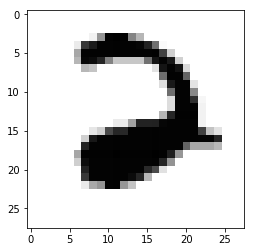

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"


# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)


index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

In [3]:
first = 20
image = torch.from_numpy(train_data[0][first])
print(image.shape) # flat image of dim (784,)

# reshape the tensor so it is represented as a batch containing a single image
# -1 means "all remaining elements", here it would be equivalent to image.reshape(1, 784)
image = image.reshape(1, -1)
print(image.shape) # flat image of dim (1, 784)

torch.Size([784])
torch.Size([1, 784])


In [4]:
# Constructing a batched input
batch_size = 10
first = 20

# the cat() function concatenates a list of tensor along a dimension
batch_input = torch.cat(
    [
        # we reshape the image tensor so it has dimension (1, 784)
        torch.from_numpy(image).reshape(1, -1)
        for image in train_data[0][first:first + batch_size]
    ],
    # we want to concatenate on the batch dimension
    dim=0
)
print(batch_input.shape)  # batch of ten flat images (10, 784)

torch.Size([10, 784])


## Encoder 

* Compute a hidden representation:  $z=relu(W^1x+b^1)$.
* Compute the means of the normal distributions:  $mu=W^2x+b^2$.
* Compute the log variance of the normal distributions:  $log\_sigma\_squared=W^3x+b^3$.

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 2)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        
        k = F.relu(self.fc1(x))
        mu = self.fc2(k)
        log_sigma_squared = self.fc3(k)
        
        # reparametrization trick
        
        std_tmp = log_sigma_squared.mul(0.5).exp_()
        e = torch.FloatTensor(std_tmp.size()).normal_()
        z = e.mul(std_tmp).add_(mu)
        
        return z, mu, log_sigma_squared
    

## Decoder

It is a simple MLP.

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden = nn.Linear(2, 100)
        self.out = nn.Linear(100, 784)
        
    def forward(self, x):

        z = F.relu(self.hidden(x))
        return self.out(z)

## Loss

For the reconstruction loss, use the Binary Cross Entropy loss:

In [7]:
loss = nn.BCEWithLogitsLoss(reduction="sum")

The formula of the KL divergence with the prior is as follows:

In [8]:
def loss_function(batch, x, mean, log_sigma):
    # error reconstruction
    recons_error = loss(batch, x)
    # KL divergence
    KL_div = mean.pow(2).add_(log_sigma.exp()).mul_(-1).add_(1).add_(log_sigma)
    KL_div = torch.sum(KL_div).mul_(-0.5)
    # total loss
    t_loss =  KL_div + recons_error
    return t_loss

## Training

##### Recomended hyperparameter :
* Optimizer : Adam
* N. epochs : 50
* Use gradient clipping
* Large batch size, e.g. 128

In [9]:
def get_batches(data):
    batches =  [torch.from_numpy(data[0][i:i+batch_size]) for i in range(0, len(data[0]), batch_size)]
    return(batches)

def train(encoder, decoder):
    
    #optimizer
    optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()))
    
    start_time = time.time()
    
    for epoch in range(Epochs):
        # train mode
        encoder.train()
        decoder.train()
        
        mean_loss = 0
        
        for x in get_batches(train_data):
            # forward
            z, mean, std = encoder(x)
            reconstructed = decoder(z)
            Loss = loss_function(reconstructed, x, mean, std)
            
            # mean loss
            mean_loss += Loss.item()/(len(train_data[0]) * batch_size)
            
            # udpate
            optimizer.zero_grad()
            Loss.backward()
            torch.nn.utils.clip_grad_value_(chain(encoder.parameters(), decoder.parameters()), 5.)
            optimizer.step()
            
        print("in epoch = ", epoch, " training loss = ", mean_loss)
    
    duration = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print("Training finish in ", duration)

In [10]:
##Recomended hyperparameter
Epochs = 50
batch_size = 128
# training
Decoder = Decoder()
Encoder = Encoder()
train(Encoder, Decoder)

in epoch =  0  training loss =  1.621596943817139
in epoch =  1  training loss =  1.3610474234008803
in epoch =  2  training loss =  1.3130235847473137
in epoch =  3  training loss =  1.2952627339172353
in epoch =  4  training loss =  1.2831251457214357
in epoch =  5  training loss =  1.274304443054199
in epoch =  6  training loss =  1.266865034484862
in epoch =  7  training loss =  1.2603376704406732
in epoch =  8  training loss =  1.2544257232666014
in epoch =  9  training loss =  1.248815442199707
in epoch =  10  training loss =  1.244352988891601
in epoch =  11  training loss =  1.2399838766479503
in epoch =  12  training loss =  1.2362778343200684
in epoch =  13  training loss =  1.2331795849609366
in epoch =  14  training loss =  1.230121720428467
in epoch =  15  training loss =  1.2274957473754886
in epoch =  16  training loss =  1.2251807649230948
in epoch =  17  training loss =  1.2229579133605943
in epoch =  18  training loss =  1.2211712791442872
in epoch =  19  training los

## Generate new images

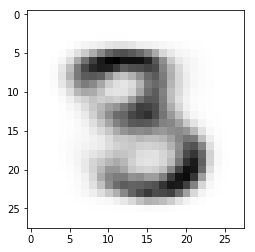

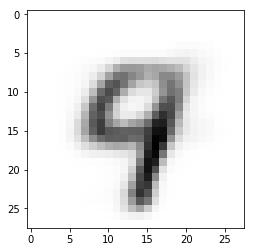

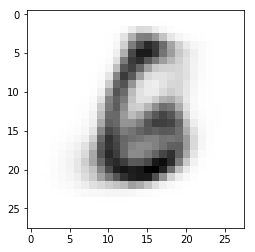

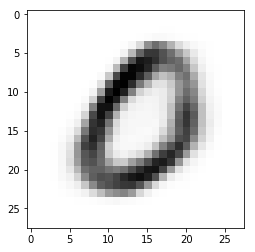

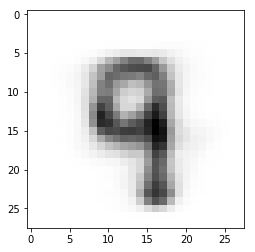

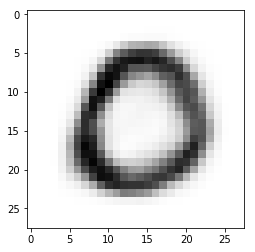

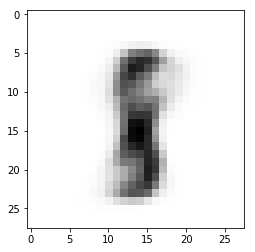

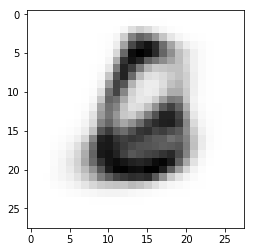

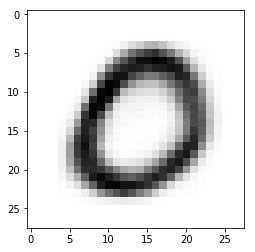

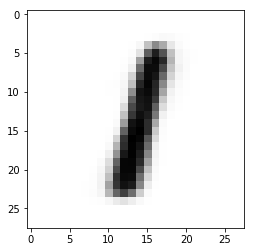

In [12]:
e = torch.normal(0, 1., (10, 2))
images = Decoder(e).sigmoid()

for i in range(10):
    picture = images[i].clone().detach().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.show()